<a href="https://colab.research.google.com/github/kushwahapushkar/Portfolio_Optimizer/blob/main/Portfolio_Optimization_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  4 of 4 completed


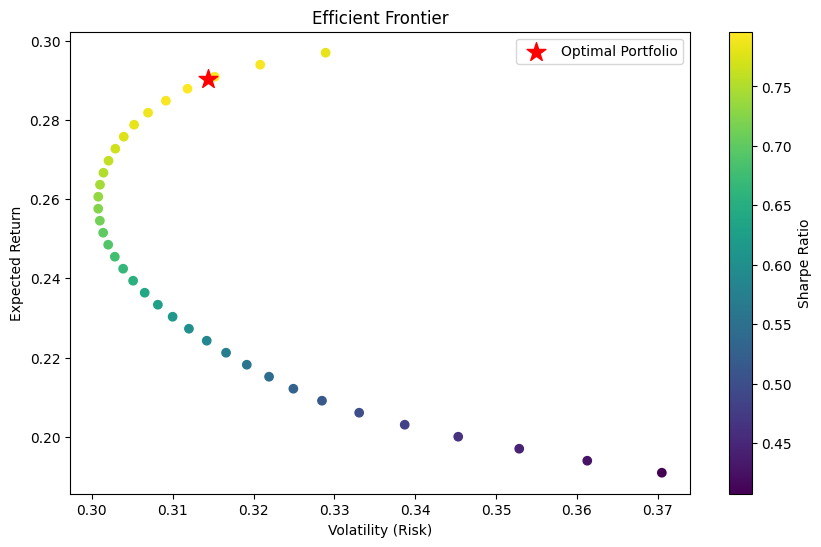

Optimal Weights:
AAPL: 62.25%
MSFT: 0.00%
GOOGL: 0.00%
AMZN: 37.75%

Expected Annual Return: 29.03%
Annual Volatility: 31.43%
Sharpe Ratio: 0.80


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------------
# 1. Download stock data
# ----------------------------
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"]  # You can change this
data = yf.download(tickers, start="2020-01-01", end="2024-01-01", auto_adjust=False)["Adj Close"]

# Compute daily returns
returns = data.pct_change().dropna()

# Mean returns & covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Risk-free rate (approx, US 10y bond ~ 4%)
rf_rate = 0.04

# ----------------------------
# 2. Portfolio performance
# ----------------------------
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # Annual return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Annual vol
    sharpe = (returns - rf_rate) / volatility
    return returns, volatility, sharpe

# ----------------------------
# 3. Optimization
# ----------------------------
def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

def get_optimal_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short-selling
    initial_guess = num_assets * [1. / num_assets]

    result = minimize(neg_sharpe_ratio, initial_guess,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints)
    return result

# Optimize portfolio
optimal_result = get_optimal_portfolio(mean_returns, cov_matrix)
optimal_weights = optimal_result.x

# ----------------------------
# 4. Efficient Frontier
# ----------------------------
def efficient_frontier(mean_returns, cov_matrix, num_points=100):
    results = {"returns": [], "volatility": [], "sharpe": []}

    num_assets = len(mean_returns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    for ret_target in np.linspace(0.1, 0.4, num_points):  # target returns
        constraints2 = (
            constraints,
            {'type': 'eq', 'fun': lambda x: np.sum(mean_returns * x) * 252 - ret_target}
        )

        result = minimize(lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix * 252, w))),
                          num_assets * [1. / num_assets], args=(),
                          method='SLSQP', bounds=bounds, constraints=constraints2)

        if result.success:
            vol = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix * 252, result.x)))
            results["returns"].append(ret_target)
            results["volatility"].append(vol)
            results["sharpe"].append((ret_target - rf_rate) / vol)
    return results

# Generate efficient frontier
ef_results = efficient_frontier(mean_returns, cov_matrix)

# ----------------------------
# 5. Visualization
# ----------------------------
plt.figure(figsize=(10,6))
plt.scatter(ef_results["volatility"], ef_results["returns"], c=ef_results["sharpe"], cmap="viridis")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

# Mark optimal portfolio
opt_ret, opt_vol, opt_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
plt.scatter(opt_vol, opt_ret, c="red", marker="*", s=200, label="Optimal Portfolio")
plt.legend()
plt.show()

# ----------------------------
# 6. Print Results
# ----------------------------
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")
print(f"\nExpected Annual Return: {opt_ret:.2%}")
print(f"Annual Volatility: {opt_vol:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")